# This notebook serves as walkthrough for planning an experiment for creation through the OT2.
### The following modules are used and should be in the same directory as this notebook: 
* **CreateSamples** is responsible for calculating sample information, which includes component weight fractions and stock volumes
* **OT2Commands** is responsible for setting up information to be interpretted and executed by opentrons.
* **OT2Graphing** contains graphing tools to help visualize and explore parameter spaces.

In [1]:
import CreateSamples
import OT2Commands as ALH
import OT2Graphing as ographing
from opentrons import simulate, execute, protocol_api

import importlib # for reloading packages

C:\Users\Edwin\.opentrons\deck_calibration.json not found. Loading defaults
C:\Users\Edwin\.opentrons\robot_settings.json not found. Loading defaults


Loading json containers...
Json container file load complete, listing database
Found 0 containers to add. Starting migration...
Database migration complete!


In [2]:
importlib.reload(CreateSamples)
importlib.reload(ALH)
importlib.reload(ographing)

<module 'OT2Graphing' from 'C:\\Users\\Edwin\\Desktop\\OT2-DOE\\Plan and Prepare\\OT2Graphing.py'>

## Step 1: Set up the experiment dictionary.
* The first step to planning an experiment is to load the experiment variables and inputs from a csv file. Every variable should have an input with an acceptable datatype. At the moment this step is done by opening a CSV file in Excel, where the first column is the name of the variable and the adjacent column is the variable value. The default delimitter is (,). 
    * Reading directly as csv is fine but it requires you have correctly format strings. This forces you to put marks ('') around each string variable value when planning the experiment. NOTE: You still need to place marks around anything inside a dtype i.e components inside a list ["component 1", component 2"]. However you do not need to place it around numbers or other dtypes.
        * To remove this dependency we can build our own interpreters for our specfic cases such as to not use ast.literal_evals default unpacking.
    * Loading from excel can be done in a similar manner but is avoided due not having xlrd or openpyxl depdenency native to python, and the opentrons being limited in the packages we can add/update. Hence we default to a CSV.
* The experiment dictionary consist of keys being the variable name and the value being the variables value. It is important to always keep in mind the order of every variable is linear and should be assumed to be match all other variables (i.e. Component Shorthand Names index 1 = Component Concentration index 1). This assumption is the default for any function using variables from the experiment dictionary, however we can deviate it from it if needed. 
    * **Note:** Most functions rely on static variable names from the dict (i.e. dict['name']). ***Refrain from changing variable names***

In [54]:
experiment_plan_path = r"C:\Users\Edwin\Desktop\OT2-DOE\Plan and Prepare\Testing Plans\02_25_21_Ouzo_Search.csv"
experiment_csv_dict = CreateSamples.get_experiment_plan(experiment_plan_path) 

## Step 1a Optional: Load custom labware dictionary (Remote Testing)
* Provide the path to the directory holding all custom labware. This directory should have custom labware .json files you have previously made and tested, read more here: https://support.opentrons.com/en/articles/3136504-creating-custom-labware-definitions
* The reason we provide this is when working on a device that is not connected to the OT2's Jupyter notebook there is no way to natively use custom labware. So we create a dictionary of custom labware so we can later load into our protocol to primarily simualte and test protocols for execution later once connnected to the OT2's notebook.
    * When using custom labware on the OT2's notebook it pulls from a folder labeled "labware", which is something built into the Opentrons hardware. It has not been tested if the custom labware dictionary will superceed this directory of custom labware if used on the OT2.
    * The custom labware folder should contain everything the OT2 labware folder contains: ADD GDRIVE link to customize
    
* **NOTE: Any function using the custom_labware_dict, the argument is optional so can remove and should receive same output IF working on OT2 computer.**

In [55]:
labware_dir_path = r"C:\Users\Edwin\Desktop\OT2-DOE\Plan and Prepare\Custom Labware"
custom_labware_dict = ALH.custom_labware_dict(labware_dir_path)

## Step 2: Select and Create Sampling Space
* Create sampling space depending on the units of concentration and method of sampling. All information is pulled from the experimental dictionary made in Step 1.
    * Currently the only sampling method available are simple lattice and random based sampling through the *CreateSamples.generate_candidate_lattice_concentrations* function. There are two potential ways to create samples in a system of n components which currently utilzie the linspaces of concentration. 
        * *Remember the linspace of concentration refers to [minimum concentration, maximum concentration, concentration step size]*
    * **Case 1 (Completing case):** Specify all but one (in this case the last) component's concentrations, which with the addition of exposing the unity_filter = True, would calculate the the remaining concentraiton values using the information of the last index of all component related variables (i.e. names). This is only meant for units that require unity like volf, wtf, and molf. 
    * **Case 2 (Non-completing case):** Specify all concentration linspaces, not applying any unit based filters, meant for all other non interdepedent units like molarity and mg/mL.
* Other things to take into consideration: All units must be the same for unity based, but not for non-unity units. If you come across a new type of unit, it may be wise to add it to the native functions group of non-unity and unity units (MAKE THIS A SOLID STATIC DICT).

In [56]:
wtf_sample_canidates = CreateSamples.generate_candidate_lattice_concentrations(experiment_csv_dict, unity_filter=True)
# something interesting you can do here is after making these wtf samples you can now apply some random selection

## Step 3: Calculate Volumes of Stocks
* From the concentration values calculated in Step 2, we use those along with stock concentration information to calculate the volume of required for each sample.


* This is where things get less "*general*" each case depending on the number of stocks, common components (i.e. component A in both stock A and B) and other requirements will typically require its own function. Luckily given the commmonality of using data frames this should be quite simple. 
    * Currently the only function to calculate volumes in centered around the Ouzo emulsion systems. This system consist of 3 stocks with the solvent being ethanol and two pure stocks of ethanol and water. *CreateSamples.calculate_ouzo_volumes_from_wtf*
    * The notation of stock is solute1-solute2-soluten-solvent. 
    

* Ideally the way volumes should calculated is simply by calculating "*essential information*" = the concentration of component and the systems overall mass or volume. Using this essential information and the concentration unit of the stock, it should call the appropiate function to calcualte the volume. To determine this essential information could be the case of feeding into a general wrapper which has all possible concentration units, where it would reccommend the function and variables to calculate the appropiate volume. Many issue could arise such as having a molarity and providing a mass so would need to make sure these cases are sorted and reported back.




In [57]:
volume_sample_canidates = CreateSamples.calculate_ouzo_volumes_from_wtf(wtf_sample_canidates, experiment_csv_dict)
volume_sample_canidates

,dppc-ethanol-stock uL,dspepeg2000-ethanol-stock uL,pfh-ethanol-stock uL,ethanol-stock uL,water-stock uL,Total Sample Volume uL
0,40.000002,33.267986,0.000000,-73.267988,799.892000,799.892000
1,40.000002,33.267986,0.000000,-31.612767,757.786737,799.441958
2,40.000002,33.267986,0.000000,9.469235,715.681474,798.418697
3,40.000002,33.267986,0.000000,49.914780,673.576211,796.758979
4,40.000002,33.267986,0.000000,89.655321,631.470947,794.394256
...,...,...,...,...,...,...
375,40.000002,33.267986,202.531646,231.028321,209.618316,716.446270
376,40.000002,33.267986,202.531646,258.807338,167.513053,702.120024
377,40.000002,33.267986,202.531646,285.312365,125.407789,686.519788
378,40.000002,33.267986,202.531646,310.572769,83.302526,669.674929


## Step 4: Create Complete Component Concentration and Volume Dataframe and Apply Filters or Other Selection Criteria 

* It is essential to combine both the concentration and volume dataframes made in Step 2 and 3 into one dataframe such that when we apply filters we apply it all samples values. We do this through the *CreateSamples.combine_df* function.

### Filters: The types of filters can be added easily through dataframe logic, these are current ones in the CreateSamples module: 
   * *pipette_volume_restriction_df* = Given the lower and upper ranges of the two sets of pipettes you will use to synthesize the samples, will remove anything not in range or zero. 
       * Will filter based off the fact of a column having "stock" in the column name. 
       * Make sure both pipettes cover each other ranges.
       * Final arugment is meant if you want to restrict some volumes while not others. 
   * *total_volume_restriction_df* = Restrict total volume, mostly based on labware constraints. Column selection based on "total". 
       * Can load destination volume constraints through *ALH.find_max_dest_volume_labware*
   * *general_max_restriction_df* = provide max value and column name 
   * *general_min_restriction_df* = provide min value and column name 
   
### Selection Criteria:
   * Maybe Sample Selection? 
    
### Other: 
   * *.multiplydf(n, df)* = Will multiply a data frame by n number of times. Useful when making one sample repeatadly.
       * add complete_df = pd.concat([complete_df]*1, ignore_index=True)

In [58]:
complete_df_unfiltered = CreateSamples.combine_df(wtf_sample_canidates, volume_sample_canidates) # unfiltered

complete_df = CreateSamples.pipette_volume_restriction_df(complete_df_unfiltered, 30, 10000) # last argument is optional
max_dest_well_volume = 1500# ALH.find_max_dest_volume_labware(experiment_csv_dict, custom_labware_dict) gives error on some computers of KeyError: '_well_definition'
complete_df = CreateSamples.total_volume_restriction_df(complete_df,max_dest_well_volume)
complete_df

,dppc concentration wtf,dspepeg200 concentration wtf,pfh concentration wtf,ethanol concentration wtf,water concentration wtf,dppc-ethanol-stock uL,dspepeg2000-ethanol-stock uL,pfh-ethanol-stock uL,ethanol-stock uL,water-stock uL,Total Sample Volume uL
3,0.0001,0.000035,0.000,0.157895,0.841970,40.000002,33.267986,0.000000,49.914780,673.576211,796.758979
4,0.0001,0.000035,0.000,0.210526,0.789339,40.000002,33.267986,0.000000,89.655321,631.470947,794.394256
5,0.0001,0.000035,0.000,0.263158,0.736707,40.000002,33.267986,0.000000,128.618832,589.365684,791.252504
6,0.0001,0.000035,0.000,0.315789,0.684076,40.000002,33.267986,0.000000,166.731650,547.260421,787.260059
7,0.0001,0.000035,0.000,0.368421,0.631444,40.000002,33.267986,0.000000,203.920303,505.155158,782.343449
...,...,...,...,...,...,...,...,...,...,...,...
375,0.0001,0.000035,0.001,0.736842,0.262023,40.000002,33.267986,202.531646,231.028321,209.618316,716.446270
376,0.0001,0.000035,0.001,0.789474,0.209391,40.000002,33.267986,202.531646,258.807338,167.513053,702.120024
377,0.0001,0.000035,0.001,0.842105,0.156760,40.000002,33.267986,202.531646,285.312365,125.407789,686.519788
378,0.0001,0.000035,0.001,0.894737,0.104128,40.000002,33.267986,202.531646,310.572769,83.302526,669.674929


## Step 4a (Optional): Visual
* If you would like, you can visual the space you are sampling by calling up to 3 columns of interest from the componsitional space. The module OT2Graphing will contain helpful function to visualize the sampling space.
* NOTE: Will not work on OT2 explain whyyyy

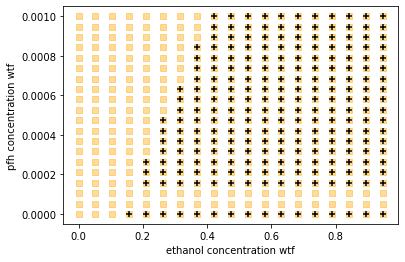

In [59]:
ographing.xy_scatter_df_compare(complete_df_unfiltered, complete_df, 'ethanol concentration wtf', 'pfh concentration wtf')
# oh wow i discovered something interesting, so originally I though that when I don't have enough space for the oil I would just increase the overall volume 
# well this can be an issue since if we have the optional restrction of Volume_Restriction on it prevents this from happening 
# well actually for some reason removing the restriction does not actually help? hmmm
# okay do one or more ouzo scan to see if you can get anything and once you find that then do the split water study..!!!

## Step 5: Addition of Blanks/Standards
* The most accurate way to blank samples or compare to standards is to create a sample without components of interest for every sample made in the prior dataframes. The way this is done will vary on the case, currently the two cases: 
    * *Common/Dependents Solvents Case:* When components are mixed in solvents for their stock that are part of other components stocks. This case requires you to not only remove the components of interest in the volume side of the dataframe, but if the removed component is part of a stock which contains a common solvent, that removed quantity must find itself back to the common solvent. The upside to this case is there is no need to update the composition/concentration poriton of the dataframe as 
    * *Independent Solvents Case:* This one is simplier as all it requires from the volume side of the dataframe is the zeroing of the volumes, however it requires you to update the compositional/concentration portion of the dataframe.


In [60]:
import pandas as pd

In [12]:
# In progress of adding and testing these

composition_df_blank = CreateSamples.isolate_common_column(complete_df, 'concentration') # add concentration to title
volume_df_blank = CreateSamples.isolate_common_column(complete_df, 'stock')
common_solvent = 'ethanol'
common_solvent_remove = []
for stock, comp in zip(volume_df_blank, composition_df_blank): # ugh have to use combination of volume and comp
    solute, solvent = CreateSamples.stock_components(stock)
    if solvent == common_solvent and len(solute) > 0:
        # then add until reached, ohh can just make new dataframe and then add finally,
        
        common_solvent_remove.append(composition_df_blank[comp].copy()) # ahh so it does edit things that are from the past
        
        composition_df_blank[comp].values[:] = 0

common_solvent_remove_df = pd.concat(common_solvent_remove, axis = 1)
common_solvent_remove_df['Total'] = common_solvent_remove_df.sum(axis=1)
        
for stock, comp in zip(volume_df_blank, composition_df_blank): 
    solute, solvent = CreateSamples.stock_components(stock)
    
    if solvent == common_solvent and len(solute) == 0:
        a = common_solvent_remove_df['Total'] 
        b = composition_df_blank[comp]
    
        c=a+b
        composition_df_blank[comp] = c
        
volume_df_blank = CreateSamples.calculate_ouzo_volumes_from_wtf(composition_df_blank, experiment_csv_dict)
volume_df_blank # unfortunately would need to filter again :(, ideally I would do this process in the begenning however there stock names are independent of the whole process
# would only need to filter again for pipette max since total wont change too much, and lower wont either?? ughhhh

complete_blank_df = CreateSamples.combine_df(composition_df_blank.reset_index(drop=True), volume_df_blank.reset_index(drop=True)) # for some reason need to drop outside of function?
complete_blank_df

,dppc concentration wtf,dspepeg200 concentration wtf,pfh concentration wtf,ethanol concentration wtf,water concentration wtf,dppc-ethanol-stock uL,dspepeg2000-ethanol-stock uL,pfh-ethanol-stock uL,ethanol-stock uL,water-stock uL,Total Sample Volume uL
0,0.0,0.0,0.0,0.222357,0.777643,0.0,0.0,0.0,322.035219,1166.464167,1488.499386
1,0.0,0.0,0.0,0.333468,0.666532,0.0,0.0,0.0,473.621118,999.797500,1473.418618
2,0.0,0.0,0.0,0.444579,0.555421,0.0,0.0,0.0,617.287430,833.130833,1450.418263
3,0.0,0.0,0.0,0.555691,0.444309,0.0,0.0,0.0,751.846967,666.464167,1418.311133
4,0.0,0.0,0.0,0.666802,0.333198,0.0,0.0,0.0,876.355264,499.797500,1376.152764
...,...,...,...,...,...,...,...,...,...,...,...
57,0.0,0.0,0.0,0.445579,0.554421,0.0,0.0,0.0,618.540719,831.630833,1450.171552
58,0.0,0.0,0.0,0.556691,0.443309,0.0,0.0,0.0,753.013533,664.964167,1417.977700
59,0.0,0.0,0.0,0.667802,0.332198,0.0,0.0,0.0,877.428149,498.297500,1375.725649
60,0.0,0.0,0.0,0.778913,0.221087,0.0,0.0,0.0,991.231205,331.630833,1322.862038


In [13]:
# merging on axis 0
complete_plus_blank = pd.concat([complete_df, complete_blank_df], ignore_index=True)
complete_plus_blank # maybe something cool would be to intertwine them so sample, blank, sample, blank. 

,dppc concentration wtf,dspepeg200 concentration wtf,pfh concentration wtf,ethanol concentration wtf,water concentration wtf,dppc-ethanol-stock uL,dspepeg2000-ethanol-stock uL,pfh-ethanol-stock uL,ethanol-stock uL,water-stock uL,Total Sample Volume uL
0,0.0001,0.000035,0.0,0.222222,0.777643,75.000004,62.377473,0.0,184.469269,1166.464167,1488.310913
1,0.0001,0.000035,0.0,0.333333,0.666532,75.000004,62.377473,0.0,336.064013,999.797500,1473.238990
2,0.0001,0.000035,0.0,0.444444,0.555421,75.000004,62.377473,0.0,479.740702,833.130833,1450.249013
3,0.0001,0.000035,0.0,0.555556,0.444309,75.000004,62.377473,0.0,614.311941,666.464167,1418.153584
4,0.0001,0.000035,0.0,0.666667,0.333198,75.000004,62.377473,0.0,738.832881,499.797500,1376.007858
...,...,...,...,...,...,...,...,...,...,...,...
119,0.0000,0.000000,0.0,0.445579,0.554421,0.000000,0.000000,0.0,618.540719,831.630833,1450.171552
120,0.0000,0.000000,0.0,0.556691,0.443309,0.000000,0.000000,0.0,753.013533,664.964167,1417.977700
121,0.0000,0.000000,0.0,0.667802,0.332198,0.000000,0.000000,0.0,877.428149,498.297500,1375.725649
122,0.0000,0.000000,0.0,0.778913,0.221087,0.000000,0.000000,0.0,991.231205,331.630833,1322.862038


In [14]:
    
# a good automatic way to do this is to find which stock names have the same solvent AND have at least one solute.
# If it does have the same solvent but not a solute then it is a pure stock and know now where to add and manipulate
# still need to decide if zeroing out the volumes then backaculating composition or zero out composition then add to pure then recaclualte volume
# I personally like the idea of just removing the wtf then recaclulting because adding the volume you are inherently adding some component trace volumm 

# oohh no but then in the case of say zero

## Step 6: Finalize and Call Seperate Concentration and Volume Dataframes
* Now that we have made the appropiate modification (filtering and addition of blanks/standards) we can finalize our dataframes. We need to seperate them on the basis of concentration and stock volume unit. 
    * At this moment this will only given that samples are the same unit, you should have received an error if this was not the case during the original creation of samples. 
    * We seperate to allow for easier handiling of creating a final dataframe for exporting and reporting volumes to the OT2 for execution/simulation.

In [61]:
final_wtf_df = CreateSamples.isolate_common_column(complete_df, 'concentration')
final_volume_df = CreateSamples.isolate_common_column(complete_df, 'stock')
final_volume_df  

,dppc-ethanol-stock uL,dspepeg2000-ethanol-stock uL,pfh-ethanol-stock uL,ethanol-stock uL,water-stock uL
3,40.000002,33.267986,0.000000,49.914780,673.576211
4,40.000002,33.267986,0.000000,89.655321,631.470947
5,40.000002,33.267986,0.000000,128.618832,589.365684
6,40.000002,33.267986,0.000000,166.731650,547.260421
7,40.000002,33.267986,0.000000,203.920303,505.155158
...,...,...,...,...,...
375,40.000002,33.267986,202.531646,231.028321,209.618316
376,40.000002,33.267986,202.531646,258.807338,167.513053
377,40.000002,33.267986,202.531646,285.312365,125.407789
378,40.000002,33.267986,202.531646,310.572769,83.302526


## Step 6 (Optional): Calculate Stock Prep Information

* We can calculate stock information to make it easier to prepare these stock. This process if semi-general, supporting a few stock concentration units = mgperml, volf, wtf, molf and molarity. All of these require the basis of volume as that is what is driving how much sample we make for the OT2. 
    * *Reccomended*: Use at the minimum the default buffering (extra stock being made) of 40 percent as from anacdotal use this will ensure you do not aspirate any air by mistake.
    * To do: So acutally have it print with concentration, just in case you go over and you can edit make some sort of fill in table and also have it return custom labels for label machine. 

In [62]:
chem_database_path = r"Chemical Database.xlsx"
stock_prep_df = CreateSamples.calculate_stock_prep_df(experiment_csv_dict, final_volume_df, chem_database_path, buffer_pct=50)
stock_prep_df

14.220000825613246
11.826768846907855


,dppc-ethanol-stock L,dspepeg2000-ethanol-stock L,pfh-ethanol-stock L,ethanol-stock L,water-stock L
solute mass g,0.028440,0.009901,0.147169,0.000000,0.000000
solute volume L,0.000000,0.000000,0.000087,0.000000,0.000000
solvent mass g,11.223847,9.334869,29.286679,71.533233,107.120406
solvent volume L,0.014220,0.011827,0.037105,0.090629,0.107120


## Step 7: Set up Ranges for Stocks
* It is important to know how many stock container will be needed for each stock and be able to provide the correct instructions for OT2 commands to follow.
    * The ranges of stock refers to the ranges of wells one stock will cover. The range is provided in terms of the index of the stock volume dataframe i.e.([lower, upper])). The format is as follows = [[stock1_range1, stock1_range2....], [stock2_range1, stock2_range2....] []...].
    * The basis of range is on the maximum volume of the stock container, however currently limitation are: 
        * All stock containers must be the same
        * Each component must have its own stock - need to test verify

In [63]:
protocol = simulate.get_protocol_api('2.0', extra_labware=custom_labware_dict)
max_source_vol = 16000# ALH.find_max_stock_volume_labware(experiment_csv_dict, custom_labware_dict)
stock_ranges = ALH.stock_well_ranges(final_volume_df, max_source_vol)
stock_ranges # atm does not call out when ranges exceed number of slots?? no it does, but have it print something so you can see where to place stock

C:\Users\Edwin\.opentrons\deck_calibration.json not found. Loading defaults
C:\Users\Edwin\.opentrons\robot_settings.json not found. Loading defaults


[[[0, 237]],
 [[0, 237]],
 [[0, 189], [189, 237]],
 [[0, 56], [56, 114], [114, 178], [178, 237]],
 [[0, 46], [46, 93], [93, 146], [146, 206], [206, 237]]]

# Step 8: Simulate/Execute
* The main information needed to create commands for the OT2 is the position of the stocks and the volumes in respect to each well you would like to move the stock to. All volumes in sent to the OT2 will be interpretted as microliters (uL). 
    * Stock Volumes: We have calculated this in step 3. It should be assumed we are making each sample in consecutive order (in order of the dataframe index). The way we prepare these samples can vary, which is what were refer to as the *pipetteing strategy*.
        * Pipetting Strategy 1: Add each stock to all wells then move onto next stock. The upside to this is the simplicity of the written protocol. It has a downside of using more tips, however parking the tip on the tiprack may resolve this (it is already being done when switching between pipettes). Also it can allow for evaporation or other time sensitve process to occur in the time between stock additions. **THIS IS CURRENTLY BEING USED DUE TO SIMPLICITY**. 
        * Pipetting Strategy 2: Adding all stocks to a well then moving on.  
        
* The way the OT2 protocols work can be read about here: https://docs.opentrons.com/v2/. Focus on the controlling with python sections. However generally this is the workflow (might add a graphic):
    1. Initiate Protocol: A protocol object must be called and this is what is essentially the brains of the process. Each protcol object is unique and you must keep track of the one you are using, so feel free to name it anything. Protocols can either be called as a simualtion or a execution. This object will allow use to initialize all labware, instrumentation and commands to the OT2. 
    2. Initiate Labware: Using the protocol object, we can call labware objects and assign them a variable name and place on the OT2 deck. All that is needed is the protocol object, name of labware (which must exist in either the native or custom directory of labwares) and the slot number. 
        * The main use of the labware is to call a well as to use an argument in a command function. These well arguments are formatted as a string, knowing this allows us to concatanate more than two labwares (i.e. 2 96 well plates) into one list to making calling more easier without having to switch labware objects. 
    3. Initiate Pipettes: Using the protocol object, we can call instrument objects which behave similarly to labware objects. These pipettes have methods which are the OT2 commands.
    4. Liquid Handling Commands: Move, Distribute, Transfer


* Currently this workflow is only split up between the initiation of the protocol/labware/pipette (***OT2Commands.loading_labware***) and the liquid handling command with the intializing step returning a dictionary with the appropiate object ready for liquid handling commands (***OT2Commands.pipette_stock_volumes***) once fed into another function. 


* ***OT2Commands.pipette_stock_volumes*** does something notable which you may want to follow in other protocols. It returns the well of every sample created in the order it was made in a list. This list is useful when populating information in the final dataframe meant for exporting and storage.

In [64]:
protocol = simulate.get_protocol_api('2.0', extra_labware=custom_labware_dict)
loaded_dict = ALH.loading_labware(protocol, experiment_csv_dict) # the protocol above has been modified globally!
info = ALH.pipette_stock_volumes(protocol, loaded_dict, final_volume_df, stock_ranges)

C:\Users\Edwin\.opentrons\deck_calibration.json not found. Loading defaults
C:\Users\Edwin\.opentrons\robot_settings.json not found. Loading defaults


Picking up tip from A1 of Opentrons 96 Tip Rack 300 µL on 10
Distributing [40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.000002322400135, 40.00

Transferring 294.2498947368422 from C3 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 to B7 of Falcon 48 Well Plate 1500 ÂµL on 5
Aspirating 294.2498947368422 uL from C3 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 1.0 speed
Dispensing 294.2498947368422 uL into B7 of Falcon 48 Well Plate 1500 ÂµL on 5 at 1.0 speed
Transferring 252.14463157894744 from C3 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 to B8 of Falcon 48 Well Plate 1500 ÂµL on 5
Aspirating 252.14463157894744 uL from C3 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 1.0 speed
Dispensing 252.14463157894744 uL into B8 of Falcon 48 Well Plate 1500 ÂµL on 5 at 1.0 speed
Transferring 210.0393684210527 from C3 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 to C1 of Falcon 48 Well Plate 1500 ÂµL on 5
Aspirating 210.0393684210527 uL from C3 of 20mLscintillation 12 Well Plate 18000 ÂµL on 1 at 1.0 speed
Dispensing 210.0393684210527 uL into C1 of Falcon 48 Well Plate 1500 ÂµL on 5 at 1.0 speed
Transferring 167

# Step 9: Format for Exporting and Upload to Google Drive
* Using the information from our previously created dataframes we create a final dataframe to convert to a csv and upload to google drive for storage. 
    * Currently the two main pieces of information uploaded are composition of sample and sample location information. This for each sample is tied to a unique ID which contains a well_timestamp_keyword. 
    * Other information you can add is stock information or stock volumes or even metadata from the opentrons (?? this would could/could not include thing like aspiration rate since this might/might not be in the experiment plan which would ideally be uploaded as well. 

* Currently the function *CreateSamples.create_df* uses information from *ALH.pipette_stock_volumes* along with the values of the composition dataframe and experiment dict to create a final df for exporting. It is not super general so will work on seperating the information slicing and dataframe combination - its quite tangeled and can be generalized. 

* Once you create your dataframe (where every row/index = one unique sample) then we can convert it to a csv and upload to google drive.

In [67]:
importlib.reload(CreateSamples)

<module 'CreateSamples' from 'C:\\Users\\Edwin\\Desktop\\OT2-DOE\\Plan and Prepare\\CreateSamples.py'>

In [72]:
export_df = CreateSamples.create_df(info['info concat'][0], final_wtf_df.values, experiment_csv_dict, unique_identifier='Rescan')
sample_info_hold = export_df.to_csv(r"sample_info", index=False)
export_df

,UID,dppc wtf,dspepeg200 wtf,pfh wtf,ethanol wtf,water wtf,Well,Labware,Slot
0,S2_A1_02-26-2021_Rescan,0.0001,0.000035,0.000,0.157895,0.841970,A1,Falcon 48 Well Plate 1500 ÂµL,2
1,S2_A2_02-26-2021_Rescan,0.0001,0.000035,0.000,0.210526,0.789339,A2,Falcon 48 Well Plate 1500 ÂµL,2
2,S2_A3_02-26-2021_Rescan,0.0001,0.000035,0.000,0.263158,0.736707,A3,Falcon 48 Well Plate 1500 ÂµL,2
3,S2_A4_02-26-2021_Rescan,0.0001,0.000035,0.000,0.315789,0.684076,A4,Falcon 48 Well Plate 1500 ÂµL,2
4,S2_A5_02-26-2021_Rescan,0.0001,0.000035,0.000,0.368421,0.631444,A5,Falcon 48 Well Plate 1500 ÂµL,2
...,...,...,...,...,...,...,...,...,...
232,S9_F1_02-26-2021_Rescan,0.0001,0.000035,0.001,0.736842,0.262023,F1,Falcon 48 Well Plate 1500 ÂµL,9
233,S9_F2_02-26-2021_Rescan,0.0001,0.000035,0.001,0.789474,0.209391,F2,Falcon 48 Well Plate 1500 ÂµL,9
234,S9_F3_02-26-2021_Rescan,0.0001,0.000035,0.001,0.842105,0.156760,F3,Falcon 48 Well Plate 1500 ÂµL,9
235,S9_F4_02-26-2021_Rescan,0.0001,0.000035,0.001,0.894737,0.104128,F4,Falcon 48 Well Plate 1500 ÂµL,9


# Navigate/Create (to) respective folder on Google Drive
1. Call an instance of your google drive, this is statically the Pozzo Team Drive using *CreateSamples.team_drive_dict()*. This should open a new window prompting you for credentials. It will also return a dictionary of the highest level folders name and unique ID. **The unique ID is what will let you navigate**
2. Once inside the Team Drive use *CreateSamples.file_and_folder_navi(unique_ID)* by selecting a certain root level folder from step 1. Then you can keep repeating this until you reach the level/directory of interest.
    * A way to bypass this is to log into google drive and find the unique ID manually EXPLAIN
3. Once you have reached the level of interest, create the folder if necessary. 
4. With the folder ID of interest then use *upload_to_team_drive_folder* providing the path and name of file along with final destination (the ID you found/made from step 2/3). This will upload the respective files to that level. 
5. Cry




* Add the option to create a new folder - as a function to the package. 
* looks like OT2 can not at all upload any sort of package - so will need to make it clear to only use the drive portion of package on remote computer - hence why we should switch to using the module and having notebooks ayt surface level.

In [73]:
CreateSamples.team_drive_dict()

{'Website': '1tmTZGkxJSvWx_6BCMXrkTVrVOv6tyBNy',
 'Photos': '1jzn8Kco19sOZOX_ylvfXaXPDuyUhxeO6',
 'Scattering Data (Zip)': '1mK7Ng9JN7QPdil97V0Qs-OD-K-_7FdnR',
 'Current Members': '1dXYmxuESNhgmVHntEf8hnZmjK0Br8b64',
 'Past Members': '1Vtib8bQXDWq0YcCTa2pfsdQg0TiDIo4e',
 'Outreach': '1wFNFEO_Oh3ofvs_r_MU1srYby5g8MlTN',
 'Lab Management': '1JO0pqhlxXKP-daj7q_vVuby_eAdqjS38',
 'Papers and Presentations': '1HPSkjct2rMuef-M7YVd1gbNM8vXNy4zp',
 'Collaborations': '1QNbjvEZRtFk4ftQFPWzt8kogPmvlYUc0'}

In [70]:
current_members = CreateSamples.file_and_folder_navi('1dXYmxuESNhgmVHntEf8hnZmjK0Br8b64')
CreateSamples.file_and_folder_navi('1CDnoLE32bG0BFhhvCl5JlRFO4I_ga-eJ')

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=976386138783-rlb4mpjsuqi7gf8qn60elpsdt46a4srl.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


{'03_03_21_Rescan': '1YdAqr1kYFEuRc8wyd9dcyzo0BWW68-1P',
 '03_03_21_RightRobot': '1YXrIIXT3uSFd5-NSpht-1wB1-7hH6Y1w',
 '03_03_21_LeftRobot': '1gQQcekJQfe4Ktvc-IrEqeNtIUbyRJIbl',
 '02_26_21_Ethanol_Water_Standards': '16UECO_E7-7y37vnmqMmnFf7haZC8h8jZ',
 '02_26_21_OuzoScan': '19v4-bQnGwFyxoRpQAggCjAC4tgGVH7Fd',
 '02_25_21_Reproducibility': '1Odb3xLOVqxpzlqBsefW9zJ6Ls80k3wRC',
 '02_17_21_Reproducibility': '14EQgsamEwie--wmwaXQgVUTuqYbn52ve',
 '02_24_21_Reproducibility': '1YV8tpbj6mhWYJDkiQzOOHgGM4wPgjaxX'}

In [74]:
plan_file_path = experiment_plan_path
synthesis_info_file_path = r"sample_info"
folder_to_place_id = '1YdAqr1kYFEuRc8wyd9dcyzo0BWW68-1P'

# CreateSamples.upload_to_team_drive_folder(folder_to_place_id, plan_file_path, 'Experiment Plan Info')
CreateSamples.upload_to_team_drive_folder(folder_to_place_id, synthesis_info_file_path, 'Experiment Synthesis Info')